<a href="https://colab.research.google.com/github/Abhiraj028/Ai_Lab/blob/master/ML_Self_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authentication and Data Processing

In [ ]:
# Import necessary libraries
from google.colab import files
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

# 1. Authenticate and download from Kaggle
DATASET_SLUG = "muhammadrehan00/chest-xray-dataset"
ZIP_FILE_NAME = "chest-xray-dataset.zip"

if not os.path.exists(f'/content/{ZIP_FILE_NAME}'):
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        uploaded = files.upload()
        os.makedirs('/root/.kaggle', exist_ok=True)
        os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
        os.chmod('/root/.kaggle/kaggle.json', 600)
    !kaggle datasets download -d {DATASET_SLUG} -p /content
else:
    print("Dataset zip file already exists.")

# 2. Unzip the dataset
!unzip -n /content/{ZIP_FILE_NAME} -d /content

# 3. Define the image preprocessing function
IMAGE_SIZE = (128, 128)
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB').resize(IMAGE_SIZE).convert('L')
    return np.array(img).flatten()

# 4. Load data from the directory structure
print("\n--- Starting Data Loading ---")
data_dirs = ['/content/train', '/content/val']
all_image_paths = []
all_image_labels = []

# Get class names by filtering for directories ONLY
train_path = data_dirs[0]
class_names = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
class_to_int = {name: i for i, name in enumerate(class_names)}
print(f"Detected class folders: {class_names}")
print(f"Class mapping: {class_to_int}")

# Collect all file paths and their corresponding integer labels
for directory in data_dirs:
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_int = class_to_int[class_name]
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                all_image_paths.append(image_path)
                all_image_labels.append(class_int)

# Process images and create final X and y arrays
print(f"\nProcessing {len(all_image_paths)} images...")
X = []
y = []
for i in tqdm(range(len(all_image_paths))):
    try:
        image_path = all_image_paths[i]
        label = all_image_labels[i]
        X.append(preprocess_image(image_path))
        y.append(label)
    except Exception as e:
        print(f"Could not process image {image_path}: {e}")

X = np.array(X)
y = np.array(y)

# 5. Final verification
print("\nData loading complete.")
print(f"Feature matrix shape (X): {X.shape}")
print(f"Label vector shape (y): {y.shape}")
print(f"VERIFICATION - Classes loaded into y: {np.unique(y, return_counts=True)}")

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/tuberculosis/tuberculosis-7118.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7119.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7120.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7121.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7122.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7123.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7124.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7125.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7126.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7127.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7128.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7129.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7130.jpg  
  inflating: /content/train/tuberculosis/tuberculosis-7131.jpg  
  inflating: /content/train/tuberculosi

  0%|          | 0/22984 [00:00<?, ?it/s]


Data loading complete.
Feature matrix shape (X): (22984, 16384)
Label vector shape (y): (22984,)
VERIFICATION - Classes loaded into y: (array([0, 1, 2]), array([8163, 5244, 9577]))


# Dataset Prep

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

USE_PCA = True


N_COMPONENTS = 945

# Set the size of the training subset.
SUBSET_SIZE = 5000

# Split the full dataset
print("Splitting the full dataset...")
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Create a smaller training subset
X_train = X_train_full[:SUBSET_SIZE]
y_train = y_train_full[:SUBSET_SIZE]
print(f"Using a subset of {len(X_train)} images for training.")

# Conditionally apply PCA
if USE_PCA:
    print(f"\nApplying PCA to reduce dimensions to {N_COMPONENTS} components...")
    pca = PCA(n_components=N_COMPONENTS, random_state=42)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print("PCA transformation complete.")
else:
    print("\nSkipping PCA.")

# Scale the data (either PCA components or raw pixels)
print("\nScaling the data...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nData preparation complete.")
print(f"Final X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")

Splitting the full dataset...
Using a subset of 5000 images for training.

Applying PCA to reduce dimensions to 945 components...
PCA transformation complete.

Scaling the data...

Data preparation complete.
Final X_train shape: (5000, 945)
Final X_test shape: (6896, 945)


Number of components needed to explain 95% of variance: 945


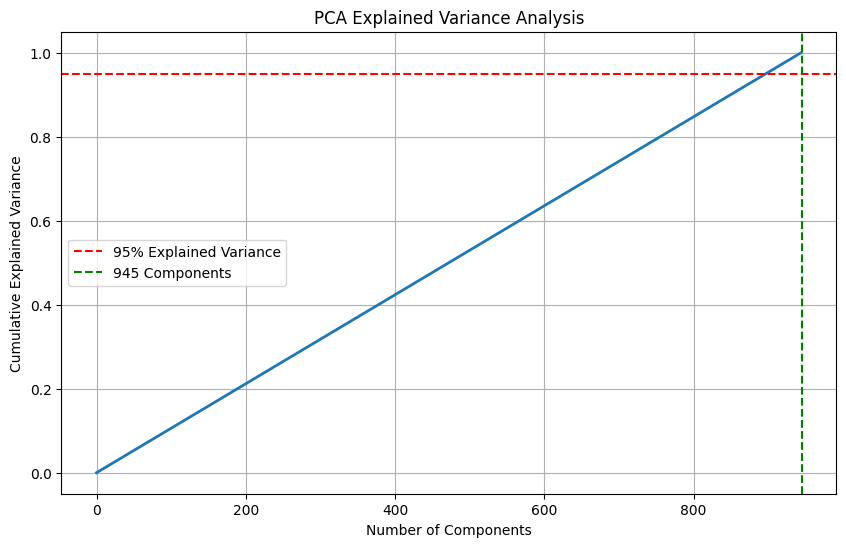

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Initialize PCA to analyze all possible components
pca_analyzer = PCA(random_state=42)
pca_analyzer.fit(X_train) # Use the scaled training data

# 2. Calculate the cumulative sum of explained variance
cumulative_variance = np.cumsum(pca_analyzer.explained_variance_ratio_)

# 3. Find the number of components to reach 95% variance
components_for_95_variance = np.argmax(cumulative_variance >= 1) + 1

print(f"Number of components needed to explain 95% of variance: {components_for_95_variance}")

# 4. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=components_for_95_variance, color='g', linestyle='--', label=f'{components_for_95_variance} Components')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Analysis")
plt.legend()
plt.grid(True)
plt.show()

# Logistic Regression

--- Logistic Regression ---
Accuracy: 0.6443

Classification Report:
              precision    recall  f1-score   support

      normal       0.55      0.54      0.54      2449
   pneumonia       0.72      0.77      0.75      1573
tuberculosis       0.68      0.67      0.67      2874

    accuracy                           0.64      6896
   macro avg       0.65      0.66      0.65      6896
weighted avg       0.64      0.64      0.64      6896



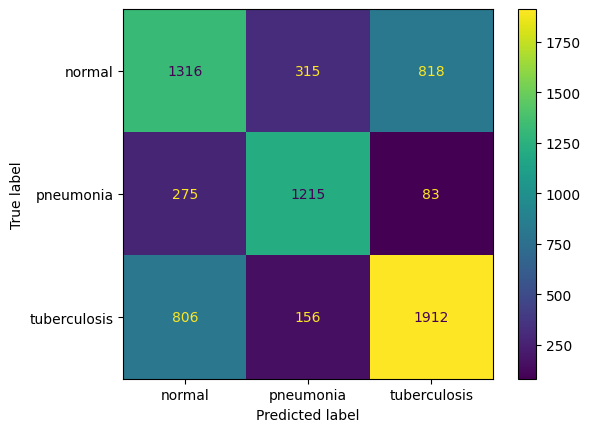

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("--- Logistic Regression ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_names)
plt.show()

# KNN

--- K-Nearest Neighbors (KNN) ---
Accuracy: 0.4157

Classification Report:
              precision    recall  f1-score   support

      normal       0.44      0.08      0.14      2449
   pneumonia       0.22      0.00      0.00      1573
tuberculosis       0.41      0.93      0.57      2874

    accuracy                           0.42      6896
   macro avg       0.36      0.34      0.24      6896
weighted avg       0.38      0.42      0.29      6896



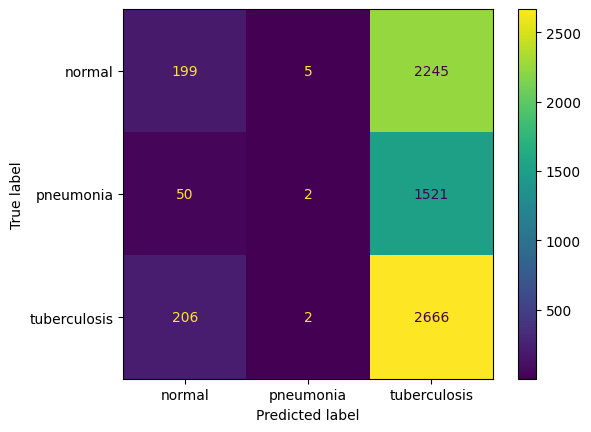

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("--- K-Nearest Neighbors (KNN) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_names)
plt.show()

# SVM

--- Support Vector Machine (SVM) ---
Accuracy: 0.6794

Classification Report:
              precision    recall  f1-score   support

      normal       0.56      0.63      0.59      2449
   pneumonia       0.85      0.74      0.79      1573
tuberculosis       0.71      0.69      0.70      2874

    accuracy                           0.68      6896
   macro avg       0.71      0.69      0.69      6896
weighted avg       0.69      0.68      0.68      6896



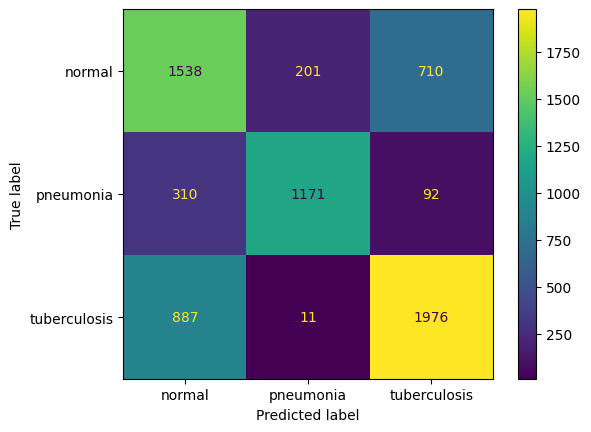

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = SVC(random_state=42, probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("--- Support Vector Machine (SVM) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_names)
plt.show()

# Bayes

--- Gaussian Naive Bayes ---
Accuracy: 0.4978

Classification Report:
              precision    recall  f1-score   support

      normal       0.40      0.64      0.49      2449
   pneumonia       0.57      0.48      0.52      1573
tuberculosis       0.67      0.39      0.49      2874

    accuracy                           0.50      6896
   macro avg       0.55      0.50      0.50      6896
weighted avg       0.55      0.50      0.50      6896



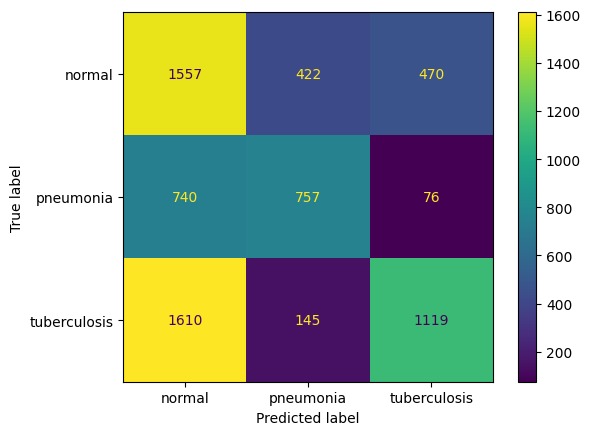

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("--- Gaussian Naive Bayes ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_names)
plt.show()

# Decision Tree

--- Decision Tree ---
Accuracy: 0.5864

Classification Report:
              precision    recall  f1-score   support

      normal       0.47      0.50      0.48      2449
   pneumonia       0.71      0.69      0.70      1573
tuberculosis       0.62      0.60      0.61      2874

    accuracy                           0.59      6896
   macro avg       0.60      0.60      0.60      6896
weighted avg       0.59      0.59      0.59      6896



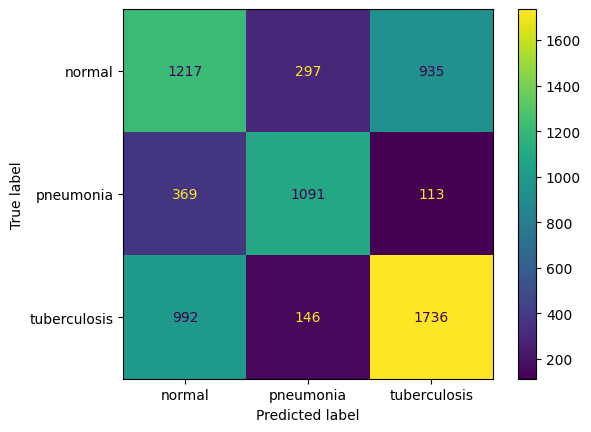

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("--- Decision Tree ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_names)
plt.show()

# Random Forest

--- Random Forest ---
Accuracy: 0.6131

Classification Report:
              precision    recall  f1-score   support

      normal       0.52      0.44      0.48      2449
   pneumonia       0.79      0.64      0.71      1573
tuberculosis       0.60      0.74      0.67      2874

    accuracy                           0.61      6896
   macro avg       0.64      0.61      0.62      6896
weighted avg       0.62      0.61      0.61      6896



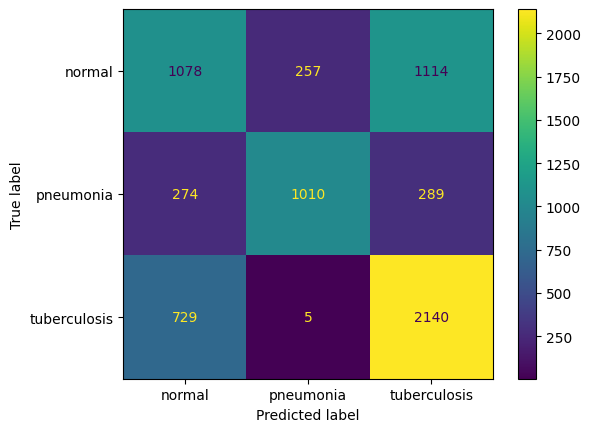

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("--- Random Forest ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_names)
plt.show()

# XgBoost

--- XGBoost ---
Accuracy: 0.6668

Classification Report:
              precision    recall  f1-score   support

      normal       0.55      0.54      0.54      2449
   pneumonia       0.81      0.84      0.82      1573
tuberculosis       0.69      0.68      0.68      2874

    accuracy                           0.67      6896
   macro avg       0.68      0.69      0.68      6896
weighted avg       0.66      0.67      0.67      6896



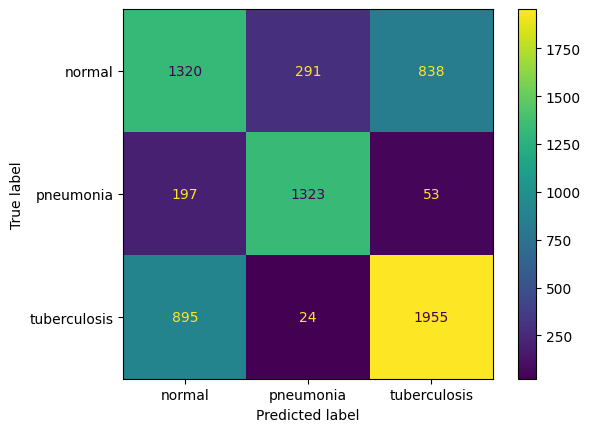

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("--- XGBoost ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_names)
plt.show()

# AdaBoost

--- AdaBoost ---
Accuracy: 0.6642

Classification Report:
              precision    recall  f1-score   support

      normal       0.57      0.52      0.54      2449
   pneumonia       0.78      0.78      0.78      1573
tuberculosis       0.67      0.73      0.70      2874

    accuracy                           0.66      6896
   macro avg       0.68      0.67      0.67      6896
weighted avg       0.66      0.66      0.66      6896



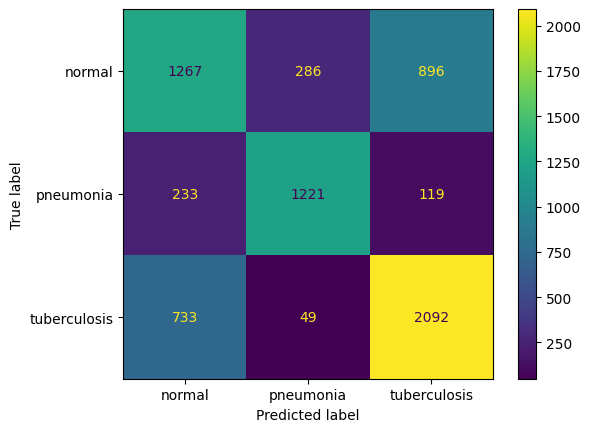

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = AdaBoostClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("--- AdaBoost ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_names)
plt.show()

# ML Perceptron

--- Multi-Layer Perceptron (MLP) ---
Accuracy: 0.6437

Classification Report:
              precision    recall  f1-score   support

      normal       0.53      0.54      0.54      2449
   pneumonia       0.80      0.75      0.77      1573
tuberculosis       0.66      0.67      0.67      2874

    accuracy                           0.64      6896
   macro avg       0.66      0.66      0.66      6896
weighted avg       0.65      0.64      0.64      6896



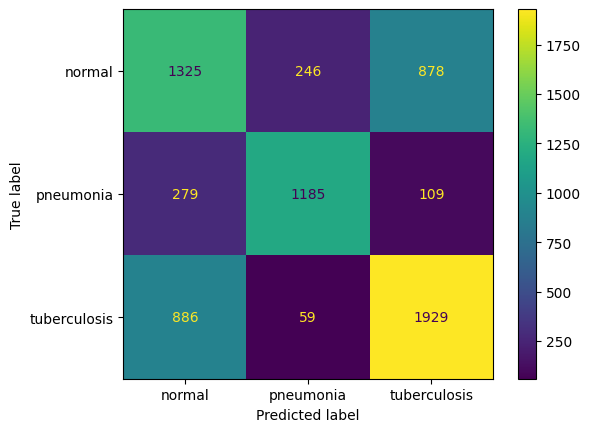

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = MLPClassifier(random_state=42, max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("--- Multi-Layer Perceptron (MLP) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_names)
plt.show()